In [1]:
import jax
import jax.numpy as jnp
import jax.random as random
from jax.scipy.special import expit, logit
import numpy as np
from tqdm import tqdm
import numpyro
import numpyro.distributions as dist
import src.Aux_functions as aux
from itertools import combinations
import matplotlib.pyplot as plt 
import time 
import blackjax 
from typing import NamedTuple, Any

print("JAX version: {}".format(jax.__version__))
print("blackjax version: {}".format(blackjax.__version__))
print("NumPyro version: {}".format(numpyro.__version__))



JAX version: 0.4.28
blackjax version: 1.2.0
NumPyro version: 0.15.2


In [19]:
logit(0.3)

Array(-0.8472978, dtype=float32, weak_type=True)

In [137]:
key = random.PRNGKey(0)
key = random.split(key, 1)[0]

RANDOM_SEED = 7
rng = np.random.default_rng(RANDOM_SEED)

# Generate some data
n = 500
triu_dim = n*(n-1)//2

# x = random.normal(key, shape=(n,))*3
x = jnp.array(rng.normal(loc=0, scale=1, size=n), dtype=jnp.float32)
# x = jnp.array(rng.normal(loc=0, scale=3, size=n), dtype=jnp.float32)
# x2 = random.binomial(key, n=1, p=0.1, shape=(n,))
x2 = jnp.array(rng.binomial(n=1, p=.1, size=n), dtype=jnp.float32)
idx_pairs = list(combinations(range(len(x)), 2))
x_diff = jnp.array([abs(x[i] - x[j]) for i, j in idx_pairs])
x2_or = jnp.array([1 if (x2[i] + x2[j] == 1) else 0 for i, j in idx_pairs])


print(x.shape, x2.shape, x_diff.shape, x2_or.shape)

# U = jnp.array(rng.normal(loc=0, scale=1, size=(n, 2)))

# def latent_to_norm_of_diff(U):
#     idx = jnp.triu_indices(n=U.shape[0], k=1)
#     U_diff = U[idx[0]] - U[idx[1]]
#     # print(U_diff.shape)
#     return jnp.linalg.norm(U_diff, axis=1)

# U_norm = latent_to_norm_of_diff(U)
# print(U_norm.shape)

# Network data

df_edges = jnp.transpose(jnp.stack([jnp.ones(triu_dim), x_diff, x2_or]))
theta = jnp.array([-2.5, -0.25, 1])
# theta = jnp.array([-2.5, -0.5, 2])
# theta = jnp.array([-2.5, -0.5, 1.5])
# gamma = jnp.array([1.1, 0.2, -1, 1])
gamma = jnp.array([logit(0.7), logit(0.2), 0.1, -0.5])
# gamma = jnp.array([logit(.85), logit(.15)])

# triu_star_probs = expit(jnp.dot(df_edges, theta) - U_norm)
triu_star_probs = expit(jnp.dot(df_edges, theta))
# triu_star = random.binomial(key, n=1, p=triu_star_probs, shape=(triu_dim,))
triu_star = jnp.array(rng.binomial(n=1, p=triu_star_probs, size=triu_dim), dtype=jnp.float32)

triu_obs_probs = expit((triu_star * gamma[0]) + (1 - triu_star) * jnp.dot(df_edges, gamma[1:]))
# triu_obs_probs = expit((triu_star * gamma[0]) + (1 - triu_star) * (gamma[1] + jnp.dot(df_edges, gamma[2:])))
# triu_obs_probs = expit(triu_star*gamma[0] + (1 - triu_star)*gamma[1])
# triu_obs = random.binomial(key, n=1, p=triu_obs_probs, shape=(triu_dim,))
triu_obs = jnp.array(rng.binomial(n=1, p=triu_obs_probs, size=triu_dim), dtype = jnp.float32)

print(triu_star.shape, triu_obs.shape)

# Outcome data

@jax.jit
def degree_centrality(adj_matrix):
    """
    Compute normalized degree centrality for all nodes in the network using JAX.
    
    Parameters:
    adj_matrix (jnp.ndarray): Square adjacency matrix (n x n)
    
    Returns:
    jnp.ndarray: Vector of normalized degree centralities
    """
    # Compute degrees (sum of rows for undirected graph)
    degrees = jnp.sum(adj_matrix, axis=1)
    
    # Normalize by maximum possible degree (n-1)
    n = adj_matrix.shape[0]
    return degrees / (n - 1)
    
@jax.jit
def compute_exposures(triu_star, Z):
    mat_star = aux.Triu_to_mat(triu_star)
    # eigen_cen = aux.eigen_centrality(mat_star)
    deg_cen = degree_centrality(mat_star)
    return aux.zeigen_value(Z, deg_cen, mat_star)

mat_star = aux.Triu_to_mat(triu_star)
# Z = random.binomial(key, n=1, p=0.5, shape=(n,))
Z = jnp.array(rng.binomial(n=1, p=0.5, size=n), dtype=jnp.float32)
# exposures = jnp.dot(mat_star, Z)
exposures = compute_exposures(triu_star, Z)

# eta = jnp.array([-1, 3, -0.25, 1, 3])
eta = jnp.array([-1, 3, -0.25, 3])
# df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, x, x2, exposures]))
df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, x, exposures]))

mean_y = jnp.dot(df_nodes, eta)
sig_y = 1

# Y = random.normal(key, shape=(n,))*sig_y + mean_y
Y =  jnp.array(mean_y + rng.normal(loc=0, scale=sig_y, size=n), dtype=jnp.float32)

print(Y.shape)



(500,) (500,) (124750,) (124750,)
(124750,) (124750,)
(500,)


mean exposure:  1.5582967 
 std exposure:  0.5065012 
 median exposure:  1.481964


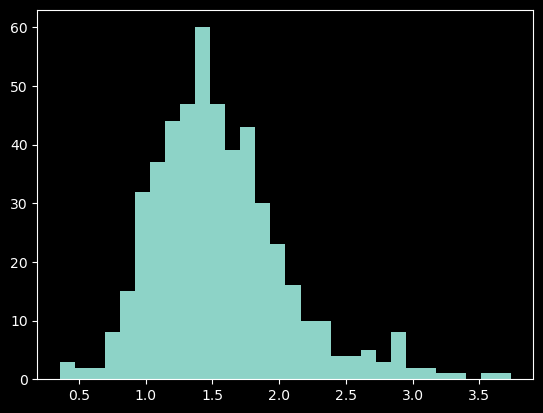

In [138]:
plt.hist(exposures, bins=30)
print("mean exposure: ", jnp.mean(exposures), "\n",
      "std exposure: ", jnp.std(exposures), "\n",
      "median exposure: ", jnp.median(exposures))

(array([  6.,  35.,  77.,  71., 112.,  87.,  32.,  25.,   5.,   2.,   2.,
          4.,   7.,   6.,   7.,   6.,   6.,   4.,   5.,   1.]),
 array([18.        , 21.70000076, 25.39999962, 29.10000038, 32.79999924,
        36.5       , 40.20000076, 43.90000153, 47.59999847, 51.29999924,
        55.        , 58.70000076, 62.40000153, 66.09999847, 69.80000305,
        73.5       , 77.19999695, 80.90000153, 84.59999847, 88.30000305,
        92.        ]),
 <BarContainer object of 20 artists>)

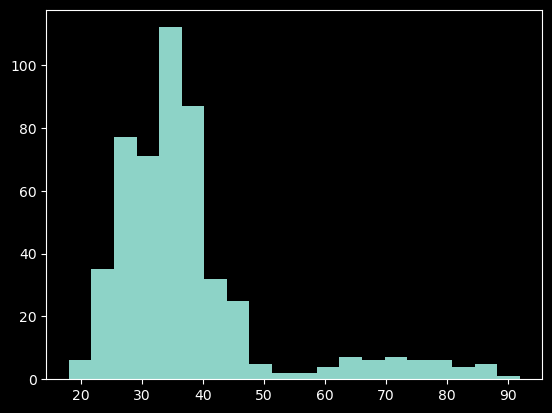

In [140]:
plt.hist(jnp.sum(mat_star, axis=1), bins=20)

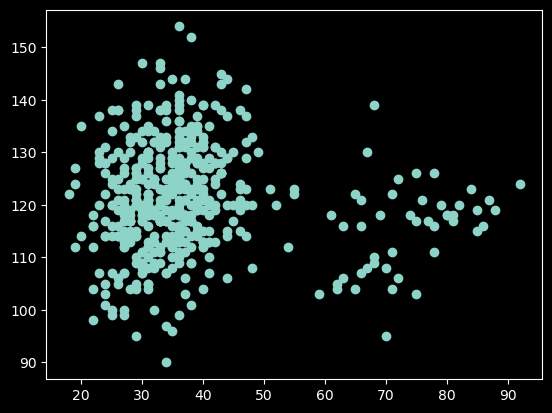

In [141]:
plt.scatter(jnp.sum(mat_star, axis=1), jnp.sum(aux.Triu_to_mat(triu_obs), axis=1))

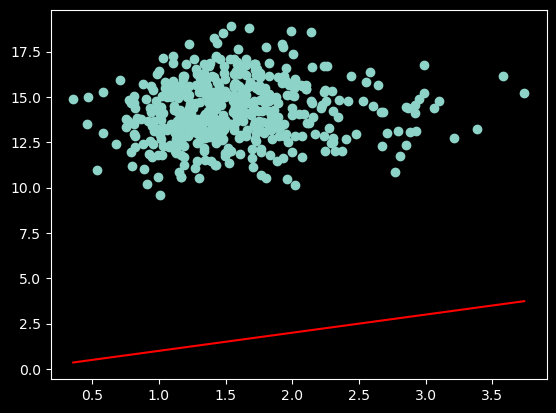

In [142]:
expos_obs = compute_exposures(triu_obs, Z)

plt.scatter(exposures, expos_obs)
# create y~x line
x_line = np.linspace(min(exposures), max(exposures), 100)
y_line = x_line
plt.plot(x_line, y_line, color='red')

(array([ 5., 17., 44., 89., 99., 99., 78., 47., 15.,  7.]),
 array([ 9.6092186 , 10.536273  , 11.46332741, 12.39038086, 13.31743526,
        14.24448967, 15.17154408, 16.09859848, 17.02565193, 17.95270729,
        18.87976074]),
 <BarContainer object of 10 artists>)

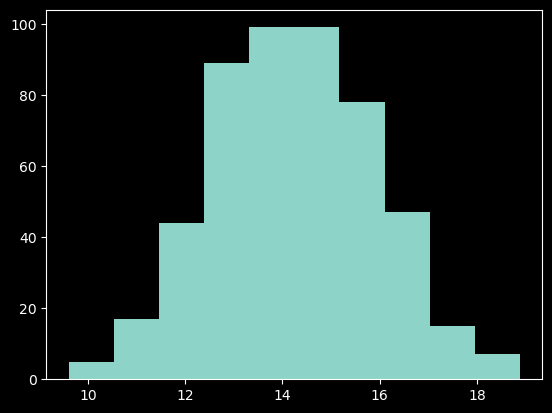

In [143]:
plt.hist(expos_obs)


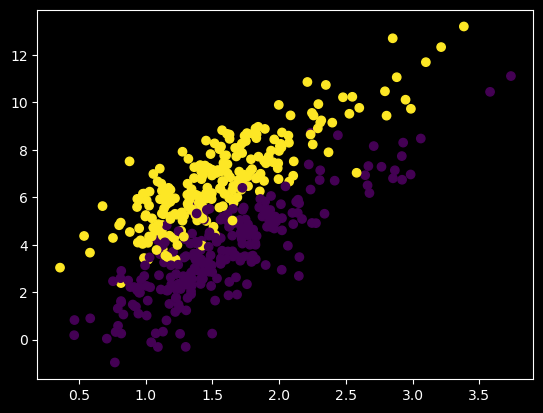

In [144]:
plt.scatter(exposures, Y, c=Z)

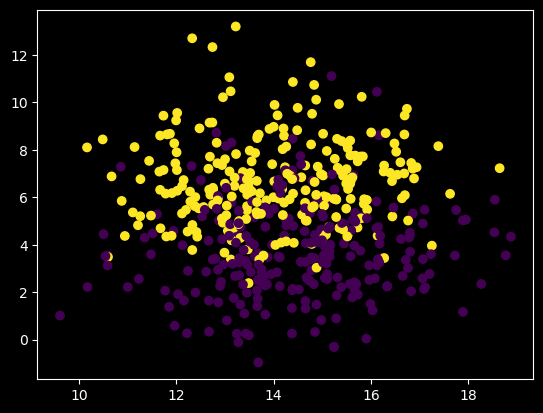

In [145]:
plt.scatter(expos_obs, Y, c=Z)

In [146]:
@jax.jit
def A_star_cond_log_post(triu_star, triu_obs, df_edges, theta, gamma):
    logits_a_star = jnp.dot(df_edges, theta)
    # a_star_log_likelihood = triu_star * (-jnp.log1p(jnp.exp(-logits_a_star))) + (1 - triu_star) * (-jnp.log1p(jnp.exp(logits_a_star)))
    a_star_log_likelihood = triu_star*logits_a_star - jnp.log1p(jnp.exp(logits_a_star))

    logits_a_obs = (triu_star * gamma[0]) + (1 - triu_star) * jnp.dot(df_edges, gamma[1:])
    # logits_a_obs = triu_star*gamma[0] + (1 - triu_star)*gamma[1]
    # a_obs_log_likelihood = triu_obs * (-jnp.log1p(jnp.exp(-logits_a_obs))) + (1 - triu_obs) * (-jnp.log1p(jnp.exp(logits_a_obs)))
    a_obs_log_likelihood = triu_obs*logits_a_obs - jnp.log1p(jnp.exp(logits_a_obs))

    log_prob = a_star_log_likelihood + a_obs_log_likelihood 
    log_prob_sum = jnp.sum(log_prob)

    return log_prob_sum, log_prob


@jax.jit
def A_star_cond_log_post_with_Y(triu_star, triu_obs, df_edges, theta, gamma, Y, X, Z, eta):
    log_prob_sum_n, log_prob_n = A_star_cond_log_post(triu_star, triu_obs, df_edges, theta, gamma)
    # curr_a_star = aux.Triu_to_mat(triu_star)
    # exposures = jnp.dot(curr_a_star, Z)
    exposures = compute_exposures(triu_star, Z)
    df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, X, exposures]))
    mean_y = jnp.dot(df_nodes, eta)
    y_log_likelihood = - 0.5 * jnp.sum((Y - mean_y)**2)

    return log_prob_sum_n + y_log_likelihood, log_prob_n + y_log_likelihood


In [61]:
print(A_star_cond_log_post(triu_star, triu_obs, df_edges, theta, gamma))
print(A_star_cond_log_post_with_Y(triu_star, triu_obs, df_edges, theta, gamma, Y, x, Z, eta))

(Array(-97109.805, dtype=float32), Array([-0.30260247, -0.30254233, -0.30524105, ..., -0.31642962,
       -0.40111744, -0.30374318], dtype=float32))
(Array(-97361.8, dtype=float32), Array([-252.29424, -252.29417, -252.29688, ..., -252.30807, -252.39276,
       -252.29538], dtype=float32))


(124750,) (124750,)
-97361.8 
 [-3.1330216 -3.30869   -3.2542048 -3.2099972 -0.8517052 -3.3014781
 -3.279843  -0.9402919 -3.2528646]


(array([2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        3.0000e+00, 3.0000e+00, 9.0000e+00, 8.0000e+00, 1.3000e+01,
        2.6000e+01, 4.5000e+01, 5.6000e+01, 1.1200e+02, 1.6500e+02,
        2.8300e+02, 4.3500e+02, 5.6600e+02, 7.3800e+02, 8.5200e+02,
        1.3070e+03, 1.9480e+03, 2.8320e+03, 4.0680e+03, 5.4980e+03,
        6.8230e+03, 8.3540e+03, 9.4150e+03, 1.0216e+04, 1.0016e+04,
        5.9210e+03, 3.6450e+03, 2.4690e+03, 1.7360e+03, 1.2360e+03,
        9.4900e+02, 7.9600e+02, 8.3200e+02, 9.6400e+02, 1.2120e+03,
        1.4560e+03, 1.7190e+03, 1.8600e+03, 2.1480e+03, 2.6290e+03,
        3.0060e+03, 3.0670e+03, 3.1550e+03, 2.5510e+03, 2.6840e+03,
        2.6470e+03, 2.4910e+03, 2.4540e+03, 1.7970e+03, 1.1290e+03,
        9.2000e+02, 6.9900e+02, 6.7500e+02, 6.0400e+02, 5.4300e+02,
        4.2600e+02, 2.1400e+02, 1.6300e+02, 1.3300e+02, 9.7000e+01,
        8.9000e+01, 8.5000e+01, 5.5000e+01, 5.9000e+01, 4.4000e+01,
        7.6000e+01, 6.1000e+01, 7.9000e+01, 7.20

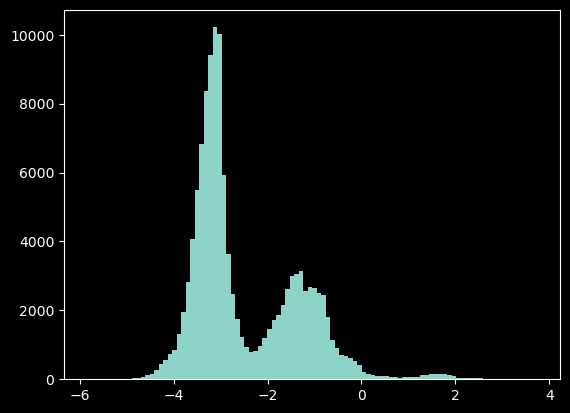

In [62]:
# val_grad_fn = jax.value_and_grad(A_star_cond_log_post, argnums=0, has_aux=True) 
val_grad_fn = jax.value_and_grad(A_star_cond_log_post_with_Y, argnums=0, has_aux=True) 

# (sum_logprob, log_prob), gradient = val_grad_fn(triu_star, triu_obs, df_edges, theta, gamma)
(sum_logprob, log_prob), gradient = val_grad_fn(triu_star, triu_obs, df_edges, theta, gamma, Y, x, Z, eta)
print(log_prob.shape, gradient.shape)
print(sum_logprob, "\n", gradient[1:10])

# create histogram of gradient

plt.hist(gradient, bins=100)

(array([2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00,
        5.0000e+00, 1.6000e+01, 3.2000e+01, 1.0300e+02, 2.0500e+02,
        4.2200e+02, 7.6500e+02, 1.3510e+03, 2.2940e+03, 3.5790e+03,
        5.3700e+03, 7.2590e+03, 9.2460e+03, 1.0937e+04, 1.1891e+04,
        1.0597e+04, 4.7910e+03, 3.1680e+03, 1.9830e+03, 1.2260e+03,
        7.2800e+02, 5.5400e+02, 5.3800e+02, 7.1700e+02, 1.0030e+03,
        1.3860e+03, 1.9370e+03, 2.4890e+03, 3.2430e+03, 3.5080e+03,
        3.6290e+03, 2.9470e+03, 3.0960e+03, 2.9330e+03, 2.9080e+03,
        2.2170e+03, 1.1950e+03, 8.7200e+02, 5.7400e+02, 3.9300e+02,
        3.3700e+02, 2.7400e+02, 4.8900e+02, 5.2400e+02, 4.5600e+02,
        3.5900e+02, 3.1200e+02, 2.1000e+02, 1.6900e+02, 1.5700e+02,
        1.1900e+02, 1.2500e+02, 1.4300e+02, 1.8000e+02, 2.3500e+02,
        2.9800e+02, 3.5900e+02, 4.9600e+02, 7.4600e+02, 7.8500e+02,
        6.9400e+02, 5.7100e+02, 4.1400e+02, 3.48

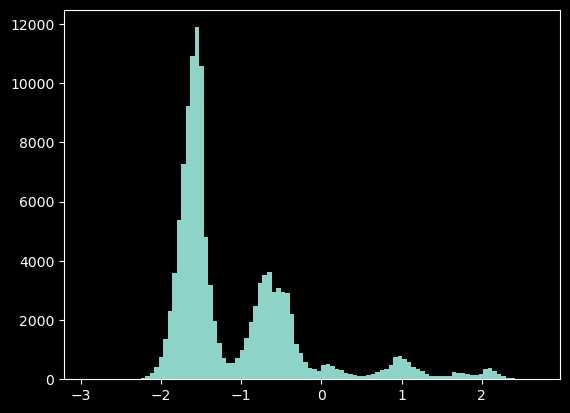

In [63]:

# score_grad = jnp.sum(-(2*triu_star-1)*gradient)
score_grad = -(2*triu_star-1)*gradient

plt.hist(score_grad/2, bins=100)

# plt.hist(grad_manual - score_grad, bins=100)

In [64]:
# g_grad = jnp.exp(score_grad) / (jnp.exp(score_grad) + 1)
# g_grad = score_grad / 2

# print(g_grad.min(), g_grad.max())
# tst_samp = random.categorical(key, logits=g_grad, shape=(1,))
# print(tst_samp, g_grad[tst_samp])

def weighted_sample_and_logprobs(key, scores, M):
    # Get samples using Gumbel-max trick
    gumbel_noise = random.gumbel(key, shape=scores.shape)
    perturbed = scores + gumbel_noise
    selected_indices = jnp.argsort(-perturbed)[:M]

     # Compute log probabilities
    # log_probs = jax.nn.log_softmax(scores)
    log_probs = jax.nn.log_softmax(scores)
    # print("min log prob: ", jnp.min(log_probs), "max log prob: ", jnp.max(log_probs), "\n",
    #       "std log prob: ", jnp.std(log_probs), "mean log prob: ", jnp.mean(log_probs), "\n",
    #       "median log prob: ", jnp.median(log_probs))
    selected_log_probs = log_probs[selected_indices]
    # print("select", selected_log_probs)

    return selected_indices, selected_log_probs.sum()

@jax.jit
def propsal_logprobs(idx, scores):
    log_probs = jax.nn.log_softmax(scores)
    return log_probs[idx].sum()



# w_samp, w_logprob = weighted_sample_and_logprobs(key, g_grad, 3)
# print(w_samp, g_grad[w_samp])
# print(w_logprob)


In [112]:
TRIU_LEN = triu_star.shape[0]
BATCH_PROP = .0005
BATCH_LEN = int(TRIU_LEN * BATCH_PROP)
# BATCH_LEN = 500
# BATCH_LEN = 5
# BATCH_LEN = 2*jnp.ceil(jnp.log(n)).astype(int)
# BATCH_LEN = 4*jnp.ceil(jnp.log(TRIU_LEN)).astype(int)
# BATCH_LEN = jnp.ceil(jnp.log(TRIU_LEN)/2).astype(int)
print(BATCH_LEN)


#TODO: update return to 'state, info' namedtuples,
#  where state contatin the current triu_star values and info logpost and acc_rate

class IPState(NamedTuple):
    positions: Any
    logdensity: float
    logdensity_grad: float
    scores: float

class IPInfo(NamedTuple):
    acceptance_rate: float
    is_accepted: bool

@jax.jit
def triu_star_kernel(rng_key, state, triu_obs, df_edges, theta, gamma,
                      Y, X, Z, eta, step_size = 1.0):

    key1, key2 = random.split(rng_key, 2)

    # (f_baseline,_), baseline_grad = val_grad_fn(triu_star, triu_obs, df_edges, theta, gamma, Y, X, Z, eta)
    # baseline_scores = (-(2*triu_star-1)*baseline_grad)/2

    # idx, forward_logprob = weighted_sample_and_logprobs(key1, cur_scores*jnp.exp(-alpha), BATCH_LEN)
    # idx, forward_logprob = weighted_sample_and_logprobs(key1, baseline_scores*jnp.exp(-step_size), BATCH_LEN)
    # idx, forward_logprob = weighted_sample_and_logprobs(key1, baseline_scores - step_size, BATCH_LEN)
    idx, forward_logprob = weighted_sample_and_logprobs(key1, state.scores - step_size, BATCH_LEN)

    # new_triu_star = triu_star.at[idx].set(1 - triu_star[idx])
    new_triu_star = state.positions.at[idx].set(1 - state.positions[idx])

    # backward proposal
    (f_proposed,_), backward_grad = val_grad_fn(new_triu_star, triu_obs, df_edges,
                                        theta, gamma, Y, X, Z, eta)
    backward_scores = (-(2*new_triu_star-1)*backward_grad)/2
    # backward_logprob = propsal_logprobs(idx, backward_scores*jnp.exp(-step_size))
    backward_logprob = propsal_logprobs(idx, backward_scores - step_size)

    # get acceptance ratio (exp of log probs)
    # acceptance_ratio = jnp.clip(jnp.exp(f_proposed - f_baseline + backward_logprob - forward_logprob),
    #                             a_max=1)
    acceptance_ratio = jnp.clip(jnp.exp(f_proposed - state.logdensity + backward_logprob - forward_logprob),
                                a_max=1)
    # accept or reject
    accept = random.uniform(key2) <= acceptance_ratio

    # update triu_star
    new_triu_star = jax.lax.select(accept, new_triu_star, state.positions)
    new_logpost = jax.lax.select(accept, f_proposed, state.logdensity)
    new_grad = jax.lax.select(accept, backward_grad, state.logdensity_grad)
    new_scores = jax.lax.select(accept, backward_scores, state.scores)
    # new_triu_star = jax.lax.select(accept, new_triu_star, triu_star)
    # new_logpost = jax.lax.select(accept, f_proposed, f_baseline)
    # new_grad = jax.lax.select(accept, backward_grad, baseline_grad)
    # new_scores = jax.lax.select(accept, backward_scores, baseline_scores)

    # return new_triu_star, acceptance_ratio
    # return new_triu_star, acceptance_ratio, new_scores, new_logpost
    state = IPState(new_triu_star, new_logpost, new_grad, new_scores)
    info = IPInfo(acceptance_ratio, accept)
    # return new_triu_star, acceptance_ratio, new_logpost
    return state, info
    
     
@jax.jit
def DMALA_kernel(rng_key, triu_star, triu_obs, df_edges, theta, gamma,
                 Y, X, Z, eta, step_size = 1.0, eps=1e-8):
    key1, key2, key3 = random.split(rng_key, 3)
    # sample idx to propose edge flip
    idx = random.choice(key1, TRIU_LEN, (BATCH_LEN,), replace=False)

    # compute baseline log-posterior and gradient
    (f_baseline,_), baseline_grad = val_grad_fn(triu_star, triu_obs, df_edges, theta, gamma, Y, X, Z, eta)
    baseline_scores = (-(2*triu_star-1)*baseline_grad)/2
    baseline_scores = baseline_scores[idx]
    baseline_std_scores = jnp.exp(baseline_scores - step_size)
    baseline_std_scores = jnp.clip(baseline_std_scores, -20, 20)
    
    # flip probablities
    baseline_flip_probs = baseline_std_scores / (1 + baseline_std_scores)

    # sample flip indicator I
    flip_indicator = random.uniform(key2, shape=(BATCH_LEN,)) < baseline_flip_probs
    
    # compute combined forward proposal q(\tilde{A}*_t|A*_t)
    forward_probs = baseline_flip_probs * flip_indicator + (1 - baseline_flip_probs) * (1 - flip_indicator)
    forward_proposal = jnp.sum(jnp.log(forward_probs + eps)) 

    # new proposed triu_star (after deciding which edges to flip)
    # it is proposed_triu_star with flipped edges only where flip_indicator is True
    new_triu_star = triu_star.at[idx].set(flip_indicator * (1 - triu_star[idx]) +
                                              (1 - flip_indicator) * triu_star[idx])

    # compute log-posterior and gradient for proposed triu_star
    (f_proposed,_), proposed_grad = val_grad_fn(new_triu_star, triu_obs, df_edges, theta, gamma, Y, X, Z, eta)
    proposed_scores = (-(2*new_triu_star-1)*proposed_grad)/2
    proposed_scores = proposed_scores[idx]
    proposed_std_scores = jnp.exp(proposed_scores - step_size)
    proposed_std_scores = jnp.clip(proposed_std_scores, -20, 20)
    backward_probs = proposed_std_scores / (1 + proposed_std_scores)

    # compute backward proposal q(A*_t|\tilde{A}*_t)
    backward_propsal = jnp.sum(jnp.log(backward_probs + eps))

    # compute acceptance ratio
    acceptance_ratio = jnp.clip(jnp.exp(f_proposed - f_baseline + backward_propsal - forward_proposal),
                                a_max=1)
    
    # accept or reject
    accept = random.uniform(key3) <= acceptance_ratio

    # update triu_star
    new_triu_star = jax.lax.select(accept, new_triu_star, triu_star)
    new_logpost = jax.lax.select(accept, f_proposed, f_baseline)
    new_grad = jax.lax.select(accept, proposed_grad, baseline_grad)
    state = IPState(new_triu_star, new_logpost, new_grad)
    info = IPInfo(acceptance_ratio, accept)
    
    return state, info
    



62


In [68]:
@jax.jit
def adaptive_step_size(alpha, acceptance_rate, target_rate=0.574, gamma=0.05):
    """
    Updates step size alpha based on the observed acceptance rate.
    """
    adjustment = gamma * (target_rate - acceptance_rate)
    return alpha + adjustment

In [66]:
# make noisy triu_star
key,_  = random.split(key)
triu_star_noisy = (triu_star * random.binomial(key, n=1, p=0.9, shape=(triu_dim,)) +
                   (1-triu_star) * random.binomial(key, n=1, p=0.1, shape=(triu_dim,)))

eta_n = eta 
eta_n = eta_n.at[3].set(eta_n[3] - 2.0)
theta_n = theta
theta_n = theta_n.at[1].set(theta_n[1] - 1.5)
# theta_n[1] = theta_n[1] - 1.5
# test A_star update

# alpha = jnp.log(2.0)
step_size = 1.0
n_iter = 1000
# n_iter = 3000
new_triu_star = triu_star_noisy
# new_triu_star = triu_obs
exposures_lst = [compute_exposures(new_triu_star, Z)]
log_post = []
acceptance_rates = []
# acceptance_rates = jnp.zeros
ADAPT_WINDOW = 100


# start = time.time()
# for i in tqdm(range(int(n_iter))):
#     key, _ = random.split(key)
  
#     new_triu_star, acc, logpost = triu_star_update(key, new_triu_star, triu_obs, df_edges,
#                                       theta, gamma, Y, x, Z, eta, step_size)
#     # new_triu_star, acc, cur_scores, cur_logpost = triu_star_update(new_triu_star,
#     #                                                                cur_scores, cur_logpost,
#     #                                                                 triu_obs, df_edges,
#     #                                   theta_n, gamma, Y, x, Z, eta_n, key, alpha=alpha)
#     exposures_lst.append(compute_exposures(new_triu_star, Z))
#     acceptance_rates.append(acc)
#     log_post.append(logpost)
    
#     if i % ADAPT_WINDOW == 0:
#         # mean_acceptance_rate = jnp.mean(jnp.array(acceptance_rates[-ADAPT_WINDOW:]))
#         mean_acceptance_rate = np.mean(acceptance_rates[-ADAPT_WINDOW:])
#         alpha = adaptive_step_size(alpha, mean_acceptance_rate)
#         print(f"Iteration {i}, New Alpha: {alpha}, Acceptance Rate: {mean_acceptance_rate}")

#         # eta_n[-1] = eta_n[-1] + 0.04
#         # eta_n = eta_n.at[3].set(eta_n[3] + 0.02)
#         # theta_n[1] = theta_n[1] + 0.03
#         # theta_n = theta_n.at[1].set(theta_n[1] + 0.015)

# print("for loop total time: ", time.time() - start)

    


In [113]:
start = time.time()

def scan_body(carry, i):
    # Unpack carry
    # key, new_triu_star, step_size, window_acceptances = carry
    key, cur_state, step_size, window_acceptances = carry
    
    # Original loop body
    key, subkey = random.split(key)
    state, info = triu_star_kernel(
        subkey, cur_state, triu_obs, df_edges,
        theta, gamma, Y, x, Z, eta, step_size
    )
    # state, info = triu_star_kernel(
    #     subkey, new_triu_star, triu_obs, df_edges,
    #     theta, gamma, Y, x, Z, eta, step_size
    # )

    
    # Handle adaptive step size
    window_acceptances = window_acceptances.at[i % ADAPT_WINDOW].set(info.acceptance_rate)
    new_step_size = jax.lax.cond(
        i % ADAPT_WINDOW == ADAPT_WINDOW - 1,
        lambda t: adaptive_step_size(t[0], jnp.mean(t[1])),
        lambda t: t[0],
        (step_size, window_acceptances)
    )
    
    # Return carry and outputs
    # new_carry = (key, new_triu_star, new_step_size, window_acceptances)
    new_carry = (key, state, new_step_size, window_acceptances)
    outputs = (state.positions, info.acceptance_rate, state.logdensity, new_step_size)
    # outputs = (new_triu_star, acc, logpost, new_step_size)
    # outputs = (exposures_s, acc, logpost, new_alpha)
    
    return new_carry, outputs

# Initialize carry values
ADAPT_WINDOW = 10
window_acceptances = jnp.zeros(ADAPT_WINDOW)

# get init state
(f_init,_), grad_init = val_grad_fn(triu_star_noisy, triu_obs, df_edges,
                                    theta, gamma, Y, x, Z, eta)
init_scores = (-(2*triu_star_noisy-1)*grad_init)/2
init_state = IPState(triu_star_noisy, f_init, grad_init, init_scores)

init_carry = (key, init_state, 1.0, window_acceptances)
# init_carry = (key, triu_star_noisy, 1.0, window_acceptances)

# Run scan
final_carry, (new_triu_star, acceptance_rates_sc, log_post_sc, alphas_sc) = jax.lax.scan(
    scan_body,
    init_carry,
    # jnp.arange(n_iter)
    jnp.arange(1500)
)


print("scan total time: ", time.time() - start)
# 

scan total time:  82.32676005363464


In [84]:
# DMALA kernel 

start = time.time()

def scan_body_dmala(carry, i):
    # Unpack carry
    key, new_triu_star, step_size, window_acceptances = carry
    
    # Original loop body
    key, subkey = random.split(key)
    state, info = DMALA_kernel(
        subkey, new_triu_star, triu_obs, df_edges,
        theta, gamma, Y, x, Z, eta, step_size
    )
    
    # Handle adaptive step size
    window_acceptances = window_acceptances.at[i % ADAPT_WINDOW].set(info.acceptance_rate)
    new_step_size = jax.lax.cond(
        i % ADAPT_WINDOW == ADAPT_WINDOW - 1,
        lambda t: adaptive_step_size(t[0], jnp.mean(t[1])),
        lambda t: t[0],
        (step_size, window_acceptances)
    )
    
    # Return carry and outputs
    # new_carry = (key, new_triu_star, new_step_size, window_acceptances)
    new_carry = (key, state.positions, new_step_size, window_acceptances)
    outputs = (state.positions, info.acceptance_rate, state.logdensity, new_step_size)
    # outputs = (new_triu_star, acc, logpost, new_step_size)
    # outputs = (exposures_s, acc, logpost, new_alpha)
    
    return new_carry, outputs

# Initialize carry values
ADAPT_WINDOW = 10
window_acceptances = jnp.zeros(ADAPT_WINDOW)
init_carry = (key, triu_star_noisy, 1.0, window_acceptances)

# Run scan
final_carry_dmala, (new_triu_star_dm, acceptance_rates_dm, log_post_dm, alphas_dm) = jax.lax.scan(
    scan_body_dmala,
    init_carry,
    # jnp.arange(n_iter)
    jnp.arange(1500)
)


print("scan DMALA total time: ", time.time() - start)
# 

scan DMALA total time:  157.80176758766174


In [116]:
print("logpost shape", log_post_sc.shape, "\n",
      # "exposures shape", exposures_sc.shape, "\n",
      "post triu_star shape", new_triu_star.shape, "\n",
      "acceptance rates shape", acceptance_rates_sc.shape, "\n",
      "alpha shape", alphas_sc.shape, "\n",
      "new_triu_star shape", final_carry[1].positions.shape)

print("logpost shape", log_post_dm.shape, "\n",
      # "exposures shape", exposures_sc.shape, "\n",
      "post triu_star shape", new_triu_star_dm.shape, "\n",
      "acceptance rates shape", acceptance_rates_dm.shape, "\n",
      "alpha shape", alphas_dm.shape, "\n",
      "new_triu_star shape", final_carry_dmala[1].shape)

logpost shape (1500,) 
 post triu_star shape (1500, 124750) 
 acceptance rates shape (1500,) 
 alpha shape (1500,) 
 new_triu_star shape (124750,)
logpost shape (1500,) 
 post triu_star shape (1500, 124750) 
 acceptance rates shape (1500,) 
 alpha shape (1500,) 
 new_triu_star shape (124750,)


In [117]:
vmap_compute_exposures = jax.vmap(compute_exposures, in_axes=(0, None))
exposures_sc = vmap_compute_exposures(new_triu_star, Z)
exposures_dmala = vmap_compute_exposures(new_triu_star_dm, Z)
print(exposures_sc.shape)
print(exposures_sc.shape, exposures_dmala.shape)

(1500, 500)
(1500, 500) (1500, 500)


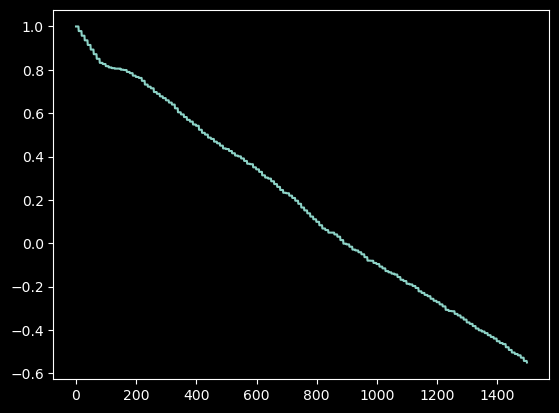

In [118]:
plt.plot(alphas_sc)

In [119]:
print(jnp.arange(1500).shape, acceptance_rates_sc.shape, acceptance_rates_sc.mean(),
      acceptance_rates_dm.mean())

(1500,) (1500,) 0.7806635 0.0


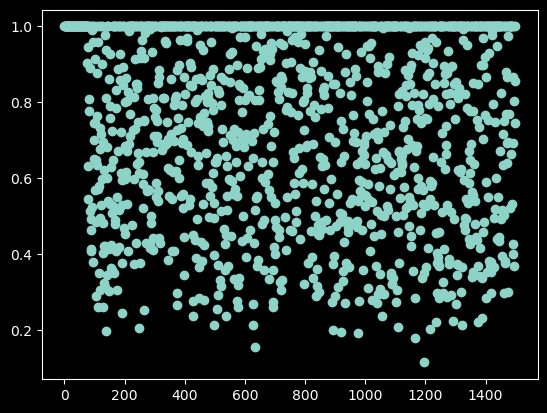

In [120]:
plt.scatter(jnp.arange(1500),acceptance_rates_sc)

(1500, 500)
2.395399
2.399058


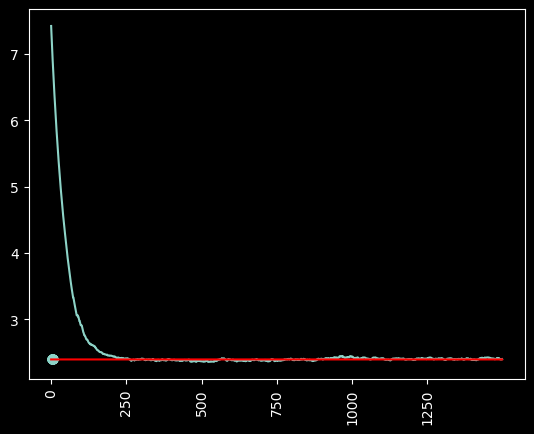

In [121]:
from sympy import rotations


# expos_arr = jnp.array(exposures_lst)[1:]
expos_arr = exposures_sc
print(expos_arr.shape)
print(exposures.mean())
plt.scatter(expos_arr.mean(axis=1), jnp.ones(expos_arr.shape[0])*exposures.mean())
print(expos_arr.mean(axis=1)[-1])

# plt.plot(expos_arr)

# create line plot of expos_arr.mean(axis=1) (y axis) vs the index (x axis)
plt.plot(expos_arr.mean(axis=1))
plt.plot(jnp.ones(expos_arr.shape[0])*exposures.mean(), color='red')
# add x-ticks vertical with 500 step siz
plt.xticks(range(0, 1500, 250), rotation=90) 
plt.show()

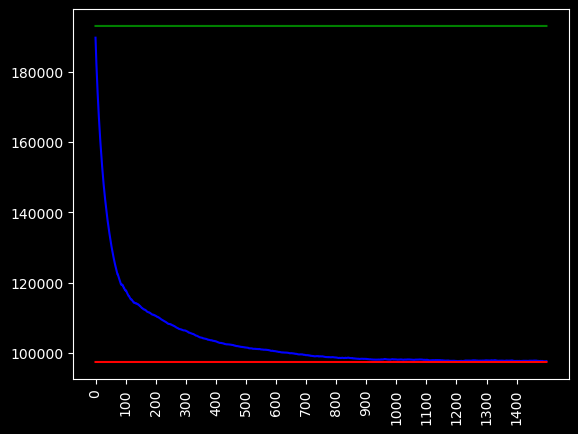

In [122]:
(true_logpost,_), true_grad = val_grad_fn(triu_star, triu_obs, df_edges,
                                            theta, gamma, Y, x, Z, eta)
# plt.ylim(70000, 180000)
plt.plot(-jnp.array(log_post_sc), color="blue")
plt.plot(-jnp.array(log_post_dm), color="green")
# plt.plot(-jnp.array(log_post), color="green")
plt.plot(-jnp.ones(len(log_post_sc))*true_logpost, color="red")
plt.xticks(range(0, 1500, 100), rotation=90)
#  set y-range to (70000, 180000)
plt.show()

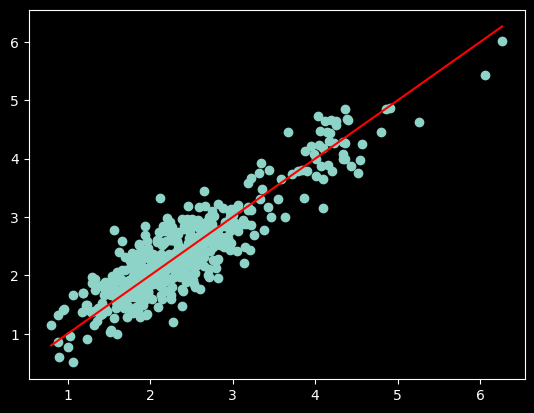

In [78]:
plt.scatter(expos_arr[-1,:], exposures)
# plt.scatter(compute_exposures(triu_obs, Z), exposures)
plt.plot([min(expos_arr[-1,:]), max(expos_arr[-1,:])], [min(expos_arr[-1,:]), max(expos_arr[-1,:])], color='red')

In [79]:
print(np.corrcoef(expos_arr[-1,:], exposures))
# print(np.corrcoef(exposures_sc[-1,:], exposures))
# print(np.corrcoef(compute_exposures(triu_star_noisy, Z), exposures))
print(np.corrcoef(compute_exposures(triu_obs, Z), exposures))

[[1.         0.90080046]
 [0.90080046 1.        ]]
[[1.         0.11534637]
 [0.11534637 1.        ]]


In [80]:
# print 2x2 table of triu_star and new_triu_star
#  for all values
def binary_contingency_table(A1, A2):
    # Table structure:
    #     A2=0  A2=1
    # A1=0  n00   n01
    # A1=1  n10   n11
    
    n00 = jnp.sum((A1 == 0) & (A2 == 0))
    n01 = jnp.sum((A1 == 0) & (A2 == 1))
    n10 = jnp.sum((A1 == 1) & (A2 == 0))
    n11 = jnp.sum((A1 == 1) & (A2 == 1))
    
    print("A1 \ A2 |  0  |  1  |")
    print("---------|-----|-----|")
    print(f"   0    | {n00:3d} | {n01:3d} |")
    print(f"   1    | {n10:3d} | {n11:3d} |")
    
    return jnp.array([[n00, n01], [n10, n11]])

# print(binary_contingency_table(triu_star, new_triu_star))
print(binary_contingency_table(triu_star, final_carry[1]))
print(binary_contingency_table(triu_star, triu_obs))

# print(jnp.mean(triu_star == new_triu_star))
print(jnp.mean(triu_star == final_carry[1]))
# print(jnp.mean(triu_star == triu_star_noisy))
print(jnp.mean(triu_star == triu_obs))


# print(jnp.sum(triu_star), jnp.sum(new_triu_star))

A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 106102 | 7582 |
   1    | 7549 | 3517 |
[[106102   7582]
 [  7549   3517]]
A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 91157 | 22527 |
   1    | 3325 | 7741 |
[[91157 22527]
 [ 3325  7741]]
0.8787094
0.7927695


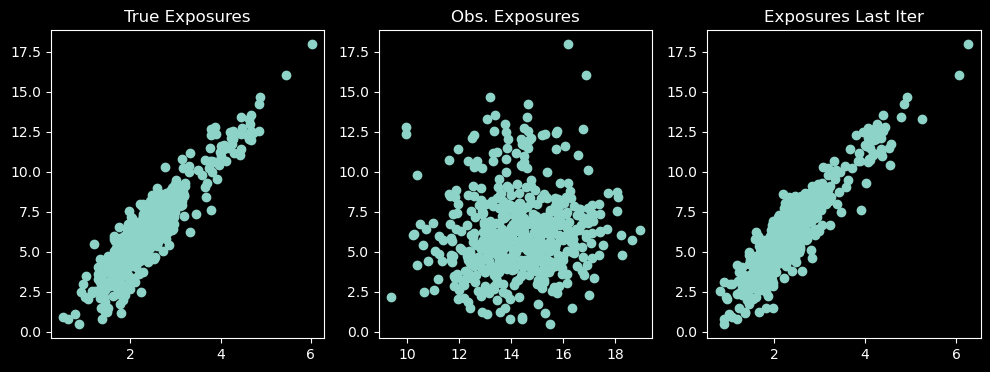

In [82]:
# plot with 3 panels of expos~Y scatter for exposures, expos_obs, expos_arr[-1,:]
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.scatter(exposures, Y-3*Z)
plt.title("True Exposures")
plt.subplot(1, 3, 2)
plt.scatter(expos_obs, Y-3*Z)
plt.title("Obs. Exposures")
plt.subplot(1, 3, 3)
plt.scatter(expos_arr[-1,:], Y-3*Z)
plt.title("Exposures Last Iter")
plt.show()


In [89]:
# Testing blackjax for continuous site (outcome model only)
import blackjax
import blackjax.mcmc.hmc as hmc
from colorama import init
import jax.scipy.stats as stats
import numpyro
import numpyro.distributions as dist
import numpyro.infer.initialization
from numpyro.infer.util import initialize_model


def outcome_model(X, Z, triu_star, Y=None):
    # Outcome model
    expos = compute_exposures(triu_star, Z)
    df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, X, expos]))

    # priors
    with numpyro.plate("eta_plate", df_nodes.shape[1]):
        eta = numpyro.sample("eta", dist.Normal(0, 5))
    
    # log_sig_y = numpyro.sample("log_sig_y", dist.Normal(0, 1))
    # sig_y = numpyro.sample("sig_y", dist.LogNormal(scale=1.0))
    sig_y = numpyro.sample("sig_y", dist.HalfNormal(2.0))
    # likelihood
    # mean_y = jnp.dot(df_nodes, eta)
    mean_y = df_nodes @ eta
    # numpyro.sample("Y", dist.Normal(mean_y, jnp.exp(log_sig_y)), obs=Y)
    numpyro.sample("Y", dist.Normal(mean_y, sig_y), obs=Y)
    
    
def networks_models(triu_star, triu_obs, df_edges):
    # Proxy nets model
    # priors
    with numpyro.plate("gamma_plate", 1 + df_edges.shape[1]):
        gamma = numpyro.sample("gamma", dist.Normal(0, 5))
    
    # likelihood
    # obs_logits = triu_star*gamma[0] + (1 - triu_star)*gamma[1]
    obs_logits = triu_star*gamma[0] + (1 - triu_star)* (df_edges @ gamma[1:])
    # obs_logits = jnp.where(triu_star == 1, gamma[0], gamma[1])
    numpyro.sample("triu_obs", dist.Bernoulli(logits=obs_logits), obs=triu_obs)

    # True network model (given triu_star value)
    # priors
    with numpyro.plate("theta_plate", df_edges.shape[1]):
        theta = numpyro.sample("theta", dist.Normal(0, 5))

    # likelihood
    # star_logits = jnp.dot(df_edges, theta)
    star_logits = df_edges @ theta
    numpyro.sample("triu_star", dist.Bernoulli(logits=star_logits), obs=triu_star)



rng_key, init_key = random.split(key)

init_params_outcome, potential_fn_gen_outcome, *_ = initialize_model(
    init_key,
    outcome_model,
    init_strategy=numpyro.infer.initialization.init_to_value(
        values={
            "eta": jnp.zeros(4),
            "sig_y": 1.0 # due to ExpTransform it equivalence of sig=0
        }
    ),
    # model_args=(x, Z, triu_star, triu_obs, df_edges, Y),
    # model_args=(x, Z, triu_obs, triu_obs, df_edges, Y),
    # model_args=(x, Z, final_carry[1], Y),
    model_args=(x, Z, triu_star, Y),
    # model_args=(x, Z, final_carry[1], Y),
    dynamic_args=True
    )

# logdensity_fn = lambda position: -potential_fn_gen(x, Z, triu_star, Y)(position)
# logdensity_fn = lambda position: -potential_fn_gen(x, Z, triu_star, triu_obs, df_edges, Y)(position)
def logdensity_fn_outcome(position):
    # return -potential_fn_gen_outcome(x, Z, final_carry[1], Y)(position)
    return -potential_fn_gen_outcome(x, Z, triu_star, Y)(position)
# logdensity_fn = lambda position: -potential_fn_gen(x, Z, final_carry[1], Y)(position)
initial_position_oc = init_params_outcome.z
print(initial_position_oc)

#  repeat for network model

init_params_network, potential_fn_gen_network, *_ = initialize_model(
    init_key,
    networks_models,
    init_strategy=numpyro.infer.initialization.init_to_value(
        values={
            "gamma": jnp.zeros(1 + df_edges.shape[1]),
            "theta": jnp.zeros(df_edges.shape[1])
        }
    ),
    model_args=(triu_star, triu_obs, df_edges),
    dynamic_args=True
    )


def logdensity_fn_network(position):
    return -potential_fn_gen_network(triu_star, triu_obs, df_edges)(position)

initial_position_net = init_params_network.z
print(initial_position_net)

{'eta': Array([0., 0., 0., 0.], dtype=float32), 'sig_y': Array(0., dtype=float32, weak_type=True)}
{'gamma': Array([0., 0., 0., 0.], dtype=float32), 'theta': Array([0., 0., 0.], dtype=float32)}


In [90]:
print(logdensity_fn_outcome(initial_position_oc))

-17615.166


In [91]:
rng_key, warmup_key = random.split(rng_key)

step_size = 1e-7
# mala kernel
# mala_oc = blackjax.mala(logdensity_fn_outcome, step_size)
mala_oc = blackjax.mala.build_kernel()
# init state
# state = mala_oc.init(initial_position_oc)
state = blackjax.mala.init(initial_position_oc, logdensity_fn_outcome)
# jit compile the kernel step function
# step = jax.jit(mala_oc.step)   
# new_state, info = step(rng_key, state)
new_state, info = mala_oc(rng_key, state, logdensity_fn_outcome, step_size)
print(new_state.position)
print(state.position)

{'eta': Array([ 0.00041278,  0.00024712, -0.00014034,  0.00155038], dtype=float32), 'sig_y': Array(0.00303269, dtype=float32, weak_type=True)}
{'eta': Array([0., 0., 0., 0.], dtype=float32), 'sig_y': Array(0., dtype=float32, weak_type=True)}


In [93]:
def inference_loop(rng_key, kernel, initial_state, logdensity_fn, step_size, num_samples):
# def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
    # def one_step(state, rng_key):
        # state, info = kernel(rng_key, state)
        state, info = kernel(rng_key, state, logdensity_fn, step_size)
        return state, (state, info.acceptance_rate)

    keys = random.split(rng_key, num_samples)
    # _, (states, acc_rate) = jax.lax.scan(one_step, initial_state, keys, logdensity_fn, step_size)
    _, (states, acc_rate) = jax.lax.scan(one_step, initial_state, keys)

    return states, (acc_rate)


num_sample = 50000
rng_key, sample_key = random.split(rng_key)
# states, acc_rates = inference_loop(sample_key, step, new_state, num_sample)
# states, acc_rates = inference_loop(sample_key, mala_oc, new_state, logdensity_fn_outcome, 1e-6, num_sample)
# _ = states.position["mu"].block_until_ready()

In [88]:
info

MALAInfo(acceptance_rate=Array(1., dtype=float32), is_accepted=Array(True, dtype=bool))

In [ ]:

class AdaptState(NamedTuple):
    state: Any  # MALA state
    step_size: float
    mean_acceptance: float
    iteration: int  

def adaptive_step_size_mala(cur_step_size, acc_rate, target_rate, adapt_rate):
    log_step = jnp.log(cur_step_size)
    log_step = log_step + adapt_rate * (acc_rate - target_rate)
    new_step_size = jnp.exp(log_step)
    return new_step_size

def inference_loop(
    rng_key, 
    kernel, 
    initial_state, 
    logdensity_fn, 
    initial_step_size: float,
    num_samples: int,
    adapt_window: int = 1,  # New parameter
    target_acceptance: float = 0.8,
    adaptation_rate: float = 0.1,
    num_warmpup: int = 5000,
):
    def one_step(carry, key):
        adapt_state = carry
        
        # Run MALA step
        new_state, info = kernel(
            key, 
            adapt_state.state, 
            logdensity_fn, 
            adapt_state.step_size
        )
        
        # Update step size only every adapt_every iterations
        should_adapt = ((adapt_state.iteration + 1) % adapt_window == 0) & (adapt_state.iteration <= num_warmpup)
        # log_step = jnp.log(adapt_state.step_size)
        # log_step = jnp.where(
        #     should_adapt,
        #     log_step + adaptation_rate * (info.acceptance_rate - target_acceptance),
        #     log_step
        # )
        # new_step_size = jnp.exp(log_step)
        new_step_size = jnp.where(
            should_adapt,
            adaptive_step_size_mala(adapt_state.step_size, 
                                    info.acceptance_rate,
                                    target_acceptance,
                                    adaptation_rate),
            adapt_state.step_size
        )
        
        # Update mean acceptance rate
        new_mean_acc = adapt_state.mean_acceptance + (
            info.acceptance_rate - adapt_state.mean_acceptance
        ) / (adapt_state.iteration + 1) # Running average accept rate 
        
        new_adapt_state = AdaptState(
            state=new_state,
            step_size=new_step_size,
            mean_acceptance=new_mean_acc,
            iteration=adapt_state.iteration + 1
        )
        
        return new_adapt_state, (new_state, info.acceptance_rate, new_step_size)

    keys = random.split(rng_key, num_samples)
    init_adapt_state = AdaptState(
        state=initial_state,
        step_size=initial_step_size,
        mean_acceptance=0.0,
        iteration=0
    )
    
    _, (states, acc_rates, step_sizes) = jax.lax.scan(one_step, init_adapt_state, keys)
    
    return states, acc_rates, step_sizes
# Usage:
states, acc_rates, step_sizes = inference_loop(
    sample_key,
    mala_oc,
    state, 
    logdensity_fn_outcome,
    initial_step_size=1e-2,
    num_samples=10000,
    target_acceptance=0.8
)

In [95]:
states

MALAState(position={'eta': Array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       ...,
       [-1.1645746 ,  3.0591655 , -0.19224343,  3.0526912 ],
       [-1.1933866 ,  3.0658011 , -0.21849127,  3.0609646 ],
       [-1.1491166 ,  3.0571659 , -0.22594114,  3.0283265 ]],      dtype=float32), 'sig_y': Array([ 0.        ,  0.        ,  0.        , ..., -0.01430709,
       -0.01941407, -0.00587687], dtype=float32, weak_type=True)}, logdensity=Array([-17615.166  , -17615.166  , -17615.166  , ...,   -723.10626,
         -722.88153,   -723.7091 ], dtype=float32), logdensity_grad={'eta': Array([[ 3.84411035e+03,  2.25123218e+03, -4.88653625e+02,
         1.02110420e+04],
       [ 3.84411035e+03,  2.25123218e+03, -4.88653625e+02,
         1.02110420e+04],
       [ 3.84411035e+03,  2.25123218e+03, -4.88653625e+02,
         1.02110420e+04],
       ...,
       [ 1.

0.8171352 0.00023558711


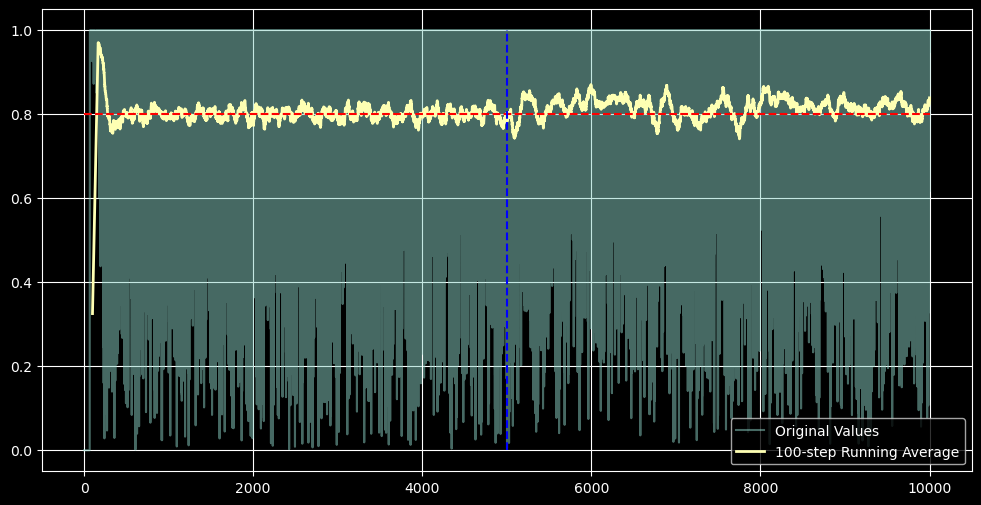

In [96]:
print(acc_rates[5000:].mean(), step_sizes[-1])
# plt.subplot(1, 2, 1)
# # plt.plot(step_sizes)
# plt.plot(step_sizes)
# plt.subplot(1, 2, 2)
# plt.plot(acc_rates)
def plot_running_average(values, window=100, hline = True):
    # Calculate running average
    running_avg = np.convolve(values, np.ones(window)/window, mode='valid')
    
    # Create x-axis values
    x_orig = np.arange(len(values))
    x_avg = np.arange(window-1, len(values))
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(x_orig, values, alpha=0.5, label='Original Values')
    plt.plot(x_avg, running_avg, linewidth=2, label=f'{window}-step Running Average')
    if hline:
        plt.hlines(0.8, 0, len(acc_rates), color='red', linestyle='--')
        plt.vlines(5000, 0, 1, color='blue', linestyle='--')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_running_average(acc_rates)

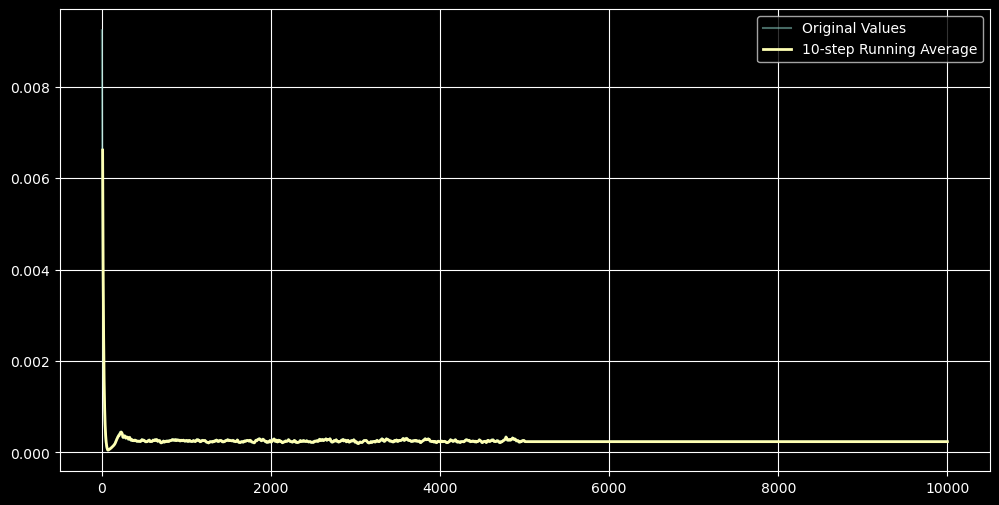

In [97]:
plot_running_average(step_sizes, hline=False, window=10)

In [98]:
eta_post = states.position["eta"][5000:,:]
sig_post = jnp.exp(states.position["sig_y"][5000:])
# sig_post = jnp.exp(states.position["log_sig_y"][20000:])
print("mean +- std by axis=1 ", jnp.mean(eta_post, axis=0), jnp.std(eta_post, axis=0))
print("mean +- std by axis=1 ", jnp.mean(sig_post, axis=0), jnp.std(sig_post, axis=0))
# gamma_post = states.position["gamma"][30000:,:]
# print("mean +- std by axis=1 ", jnp.mean(gamma_post, axis=0), jnp.std(gamma_post, axis=0))

mean +- std by axis=1  [-1.1140605   3.003013   -0.23438728  3.0543518 ] [0.1262989  0.07899238 0.04865886 0.05055361]
mean +- std by axis=1  1.0070885 0.033087246


In [100]:
# acceptance_rate = np.mean(infos)
# num_divergent = np.mean(infos[1])

print(f"\Average acceptance rate: {acceptance_rate:.2f}")

print("true gamma: ", gamma, "\n",
      "true eta: ", eta, "\n",
      "true theta: ", theta)

# print(f"There were {100*num_divergent:.2f}% divergent transitions")

NameError: name 'acceptance_rate' is not defined

In [101]:
post = {"eta" : states.position["eta"][5000:,][None, ...], 
        # "sig_y" : states.position["sig_y"][20000:,][None, ...],}
        "sig_y" : jnp.exp(states.position["sig_y"][5000:,][None, ...]),}
        # "sig_y" : jnp.exp(states.position["log_sig_y"][20000:,][None, ...]),}

print(post["eta"].shape, post["sig_y"].shape)

(1, 5000, 4) (1, 5000)


In [102]:
import matplotlib.pyplot as plt
import arviz as az

# idata = az.from_dict(posterior={k: v[None, ...] for k, v in states.position.items()}, )
idata = az.from_dict(posterior=post)
az.summary(idata)

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
eta[0],-1.114,0.126,-1.329,-0.861,0.022,0.016,32.0,93.0,NaN
eta[1],3.003,0.079,2.867,3.160,0.010,0.007,67.0,84.0,NaN
eta[2],-0.234,0.049,-0.335,-0.148,0.004,0.003,164.0,354.0,NaN
eta[3],3.054,0.051,2.958,3.143,0.009,0.006,35.0,111.0,NaN
sig_y,1.007,0.033,0.942,1.065,0.001,0.001,537.0,1012.0,NaN


array([[<Axes: title={'center': 'eta'}>, <Axes: title={'center': 'eta'}>],
       [<Axes: title={'center': 'sig_y'}>,
        <Axes: title={'center': 'sig_y'}>]], dtype=object)

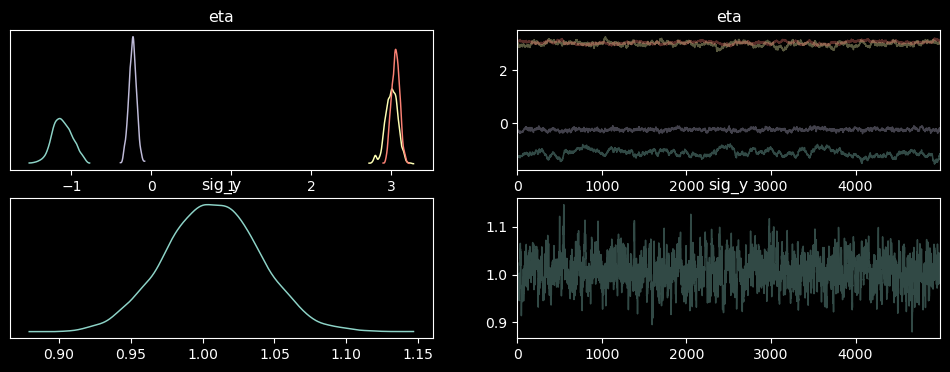

In [103]:
az.plot_trace(idata, var_names=["eta", "sig_y"])

In [104]:
# run MALA for network model

rng_key, warmup_key = random.split(rng_key)

step_size = 1e-7
# mala kernel
# mala_oc = blackjax.mala(logdensity_fn_outcome, step_size)
mala_net = blackjax.mala.build_kernel()
# init state
# state = mala_oc.init(initial_position_oc)
state = blackjax.mala.init(initial_position_net, logdensity_fn_network)
# jit compile the kernel step function
# step = jax.jit(mala_oc.step)   
# new_state, info = step(rng_key, state)
new_state, info = mala_oc(rng_key, state, logdensity_fn_network, step_size)
print(new_state.position)
print(state.position)


{'gamma': Array([0., 0., 0., 0.], dtype=float32), 'theta': Array([0., 0., 0.], dtype=float32)}
{'gamma': Array([0., 0., 0., 0.], dtype=float32), 'theta': Array([0., 0., 0.], dtype=float32)}


In [105]:
sample_key,_ = random.split(key)
net_states, net_acc_rates, net_step_sizes = inference_loop(
    sample_key,
    mala_net,
    state, 
    logdensity_fn_network,
    initial_step_size=1e-2,
    num_samples=10000,
    target_acceptance=0.8
)

0.7733175 2.0219046e-05


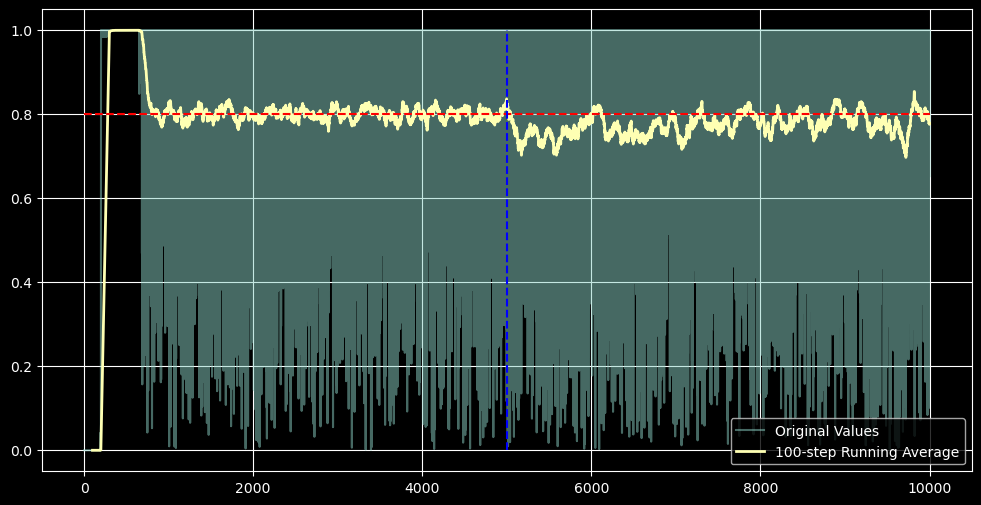

In [106]:
print(net_acc_rates[5000:].mean(), net_step_sizes[-1])
plot_running_average(net_acc_rates)

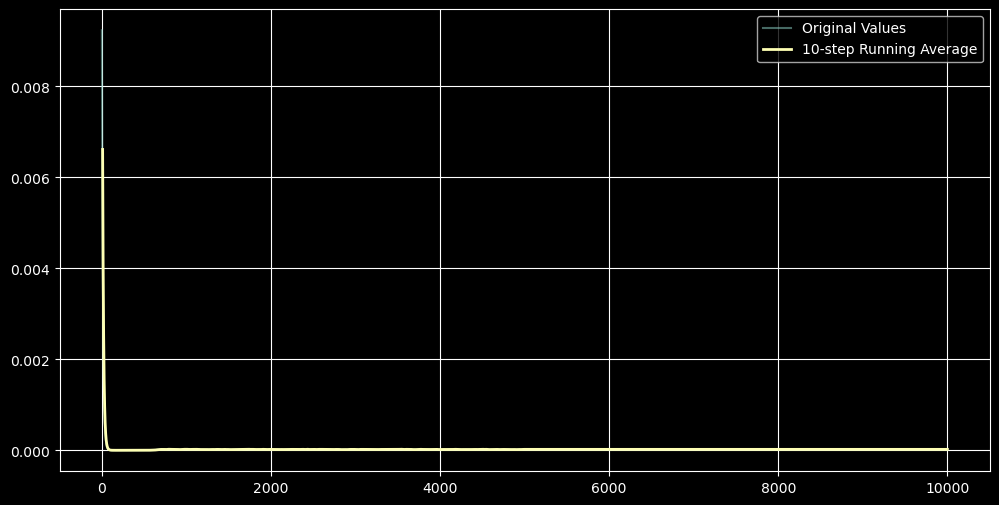

In [107]:
plot_running_average(net_step_sizes, hline=False, window=10)

In [108]:
print("true gamma: ", gamma, "\n",
      "true eta: ", eta, "\n",
      "true theta: ", theta)

net_post = {"gamma" : net_states.position["gamma"][5000:,][None, ...],
            "theta" : net_states.position["theta"][5000:,][None, ...],}



true gamma:  [ 0.84729785 -1.3862944   0.1        -1.        ] 
 true eta:  [-1.    3.   -0.25  3.  ] 
 true theta:  [-2.5  -0.25  1.5 ]


In [109]:
idata_net = az.from_dict(posterior=net_post)
az.summary(idata_net)

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma[0],0.849,0.021,0.809,0.888,0.002,0.001,123.0,214.0,NaN
gamma[1],-1.396,0.013,-1.418,-1.371,0.001,0.001,146.0,491.0,NaN
gamma[2],0.102,0.009,0.084,0.117,0.001,0.000,228.0,565.0,NaN
gamma[3],-0.972,0.028,-1.025,-0.921,0.004,0.003,49.0,109.0,NaN
theta[0],-2.507,0.020,-2.545,-2.469,0.004,0.003,22.0,207.0,NaN
theta[1],-0.272,0.015,-0.302,-0.244,0.001,0.001,113.0,328.0,NaN
theta[2],1.535,0.021,1.498,1.579,0.003,0.002,59.0,128.0,NaN


array([[<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

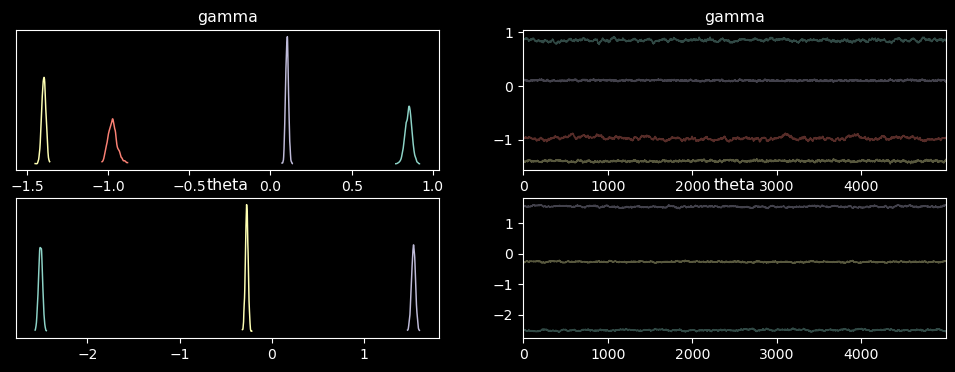

In [110]:
az.plot_trace(idata_net, var_names=["gamma", "theta"])

In [ ]:
# TODO: seperate continuous models to two: outcome (eta) and networks (gamma, theta)
# TODO: combine continuous and discrete models in one wrap function. See blackjax guide for wrapping (MWG kernel)
# https://blackjax-devs.github.io/blackjax/examples/howto_metropolis_within_gibbs.html
# TODO: the functio (^) should do warm-up stage with adaptive step size for each algo and then run the sampling
# TODO: probably preferable for now to use MALA for continuous sites due to adaptive hyper-param issues with NUTS/HMC
# TODO: see this paper https://openreview.net/forum?id=obP4120Bt34 that did sampling in mixed spaces
# TODO: think about initialisation startegies for latent variables (e.g. triu_star) in the model 
# TODO: probably should stick to GWG kernel and not DMALA for A* updates. 
# TODO: think about number of edges to update per iteration.
# The combined Gibbs-Sampling function should update the log-density function according to
#  current state of other latent variables. 